## Social Media Analytics

Pada project ini akan dilakukan analisis sentimen terhadap airline yang berada di US dengan data yang berasal dari twitter. </br>. Dataset yang digunakan terdiri atas 14.485 user dengan 15 variabel.

### Import Module

In [1]:
!pip install nltk
!pip install textblob 
!pip install tweepy
!pip install re
!pip install wordcloud 
!pip install tqdm

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Could not find a version that satisfies the requirement re (from versions: )
No matching distribution found for re
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Import Libraries

In [2]:
import pandas as pd 
import numpy as np

#Authentication module. for documentation  (http://docs.tweepy.org)
import tweepy as tp

#import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import string, regex, , uniqcode
import re, string, unicodedata

import textblob 
from textblob import TextBlob

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devita064129\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tw=pd.read_csv('tweets.csv')
tw.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


Melalukan penghapusan terhadap duplikat data 

In [4]:
g_unique = set()
for item in tw['text']:
        g_unique.add(item)
tweet = []
for item in g_unique:
    tweet.append(item)
    dataframe = pd.DataFrame(tweet,columns = ['text'])

In [5]:
dataframe.head()

,text
0,@USAirways - My guess is what happened in #Veg...
1,@USAirways thank you. We filled out a claim an...
2,@AmericanAir Worst airline. You Cancelled Flig...
3,"@SouthwestAir @nelsjeff, 3.5 hrs. Late Flightr..."
4,@VirginAmerica please contact me about portfol...


## Data Preprocessing

### 1. Lower Casing

Mengubah keseluruhan data menjadi huruf kecil.

In [6]:
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dataframe['text'].head()

0    @usairways - my guess is what happened in #veg...
1    @usairways thank you. we filled out a claim an...
2    @americanair worst airline. you cancelled flig...
3    @southwestair @nelsjeff, 3.5 hrs. late flightr...
4    @virginamerica please contact me about portfol...
Name: text, dtype: object

### 2. Punctuation Removal

Menghapus tanda baca pada data

In [7]:
dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
dataframe.head()

,text
0,usairways my guess is what happened in vegas ...
1,usairways thank you we filled out a claim and ...
2,americanair worst airline you cancelled flight...
3,southwestair nelsjeff 35 hrs late flightr no h...
4,virginamerica please contact me about portfoli...


### 3. Stopwords removal

Menghilangkan kata hubung dan domain spesifik serta mengelompokkan kata-kata yang sering digunakan dan memiliki kemiripan arti


In [8]:
stop = stopwords.words('english')
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dataframe['text'].head(10)

0    usairways guess happened vegas ended philly se...
1      usairways thank filled claim hope bags tomorrow
2    americanair worst airline cancelled flight fli...
3    southwestair nelsjeff 35 hrs late flightr huma...
4    virginamerica please contact portfolio left fl...
5    united flight cancelled flightled 4 hrs airpor...
6    southwestair cancelled flightled flight resche...
7    jetblue thanks loose em airports1st time found...
8            americanair hold againestimated 2 hr hold
9    americanair 3349 supposed little rock 10am mor...
Name: text, dtype: object

### 4. Frequent words removal

Menghilangkan data yang sering muncul

In [9]:
freq = pd.Series(' '.join(dataframe['text']).split()).value_counts()[:10]
freq

united          4125
flight          3823
usairways       3036
americanair     2791
southwestair    2440
jetblue         2349
get             1326
cancelled       1034
thanks          1030
service          948
dtype: int64

### 5. Rare words removal

Menghilangkan kata-kata aneh/ganjil

In [10]:
rare_word = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-10:]
rare_word

netneutrality    1
grandparents     1
inquiries        1
nothini          1
ua6366           1
farms            1
startling        1
stingiest        1
chaperone        1
kieranmahan      1
dtype: int64

In [11]:
rare_word = list(rare_word.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0    guess happened vegas ended philly sexy httptco...
1                thank filled claim hope bags tomorrow
2    worst airline dont let know wait hold 30 mins ...
3    nelsjeff 35 hrs late flightr human interaction...
4    virginamerica please contact portfolio left vx...
Name: text, dtype: object

### 6. Spelling correction

Memperbaiki jika terdapat kata-kata yang typo

In [12]:
dataframe['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    guess happened began ended chilly sex httptcoq...
1                thank filled claim hope bags tomorrow
2    worst airline dont let know wait hold 30 mind ...
3    nelsjeff 35 his late flight human interaction ...
4    virginamerica please contact portfolio left ve...
Name: text, dtype: object

### 7. Tokenization

Memisahkan data pada tweet

In [27]:
TextBlob(dataframe['text'][1]).words

WordList(['thank', 'fill', 'claim', 'hope', 'bag', 'tomorrow'])

### 8. Stemming

In [28]:
st = PorterStemmer()
dataframe['text'] = dataframe['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [29]:
dataframe.head()

,text
0,guess happen vega end philli sexi httptcoqgmfc...
1,thank fill claim hope bag tomorrow
2,worst airlin dont let know wait hold 30 min to...
3,nelsjeff 35 hr late flightr human interact end...
4,virginamerica plea contact portfolio left vx 2...


### 9. Lematization

Mengubah ejaan kata sesuai dengan kamus

In [16]:
from textblob import Word
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
dataframe['text'].head()

0    guess happen vega end philli sexi httptcoqgmfc...
1                   thank fill claim hope bag tomorrow
2    worst airlin dont let know wait hold 30 min to...
3    nelsjeff 35 hr late flightr human interact end...
4    virginamerica plea contact portfolio left vx 2...
Name: text, dtype: object

In [17]:
dataframe.head()

,text
0,guess happen vega end philli sexi httptcoqgmfc...
1,thank fill claim hope bag tomorrow
2,worst airlin dont let know wait hold 30 min to...
3,nelsjeff 35 hr late flightr human interact end...
4,virginamerica plea contact portfolio left vx 2...


## Wordcloud

Pada wordcloud akan ditemukan kata-kata yang sering muncul 

In [18]:
wordc = ''.join(dataframe.text.values)

In [19]:
def create_word_cloud(string):
    cloud = WordCloud(background_color = "black", 
                      max_words = 200, 
                      stopwords = set(STOPWORDS)
                     ).generate(string)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

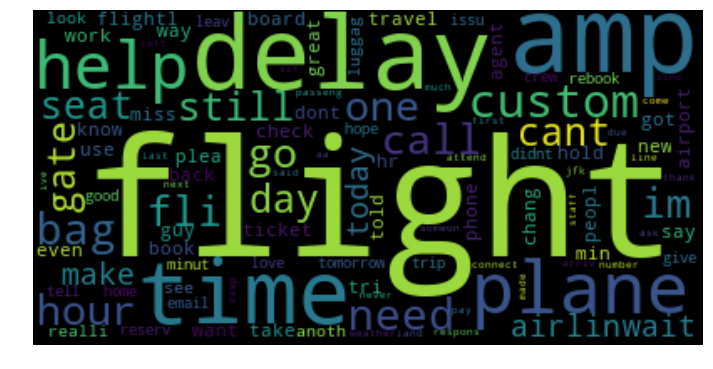

In [20]:
create_word_cloud(wordc)

Kata-kata yang sering muncul pada tweet mengenai US Airline adalah :
1. Flight
2. Delay
3. Time
4. Plane
5. Amp

**Wordcloud untuk sentimen negatif**

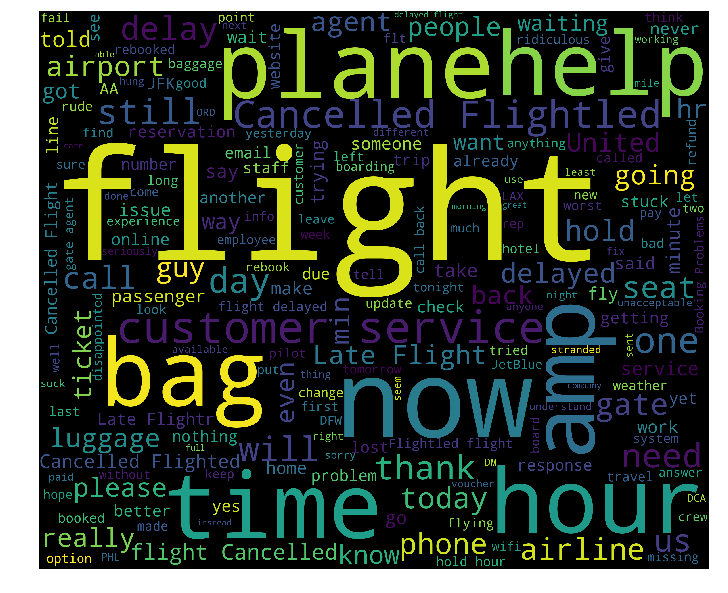

In [21]:
negative=tw[tw['airline_sentiment']=='negative']
words = ' '.join(negative['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Lima kata yang sering muncul pada sentimen negatif adalah :
1. Flight
2. Plane
3. Help
4. Bag
5. Now

**Wordcloud untuk Sentimen Netral**

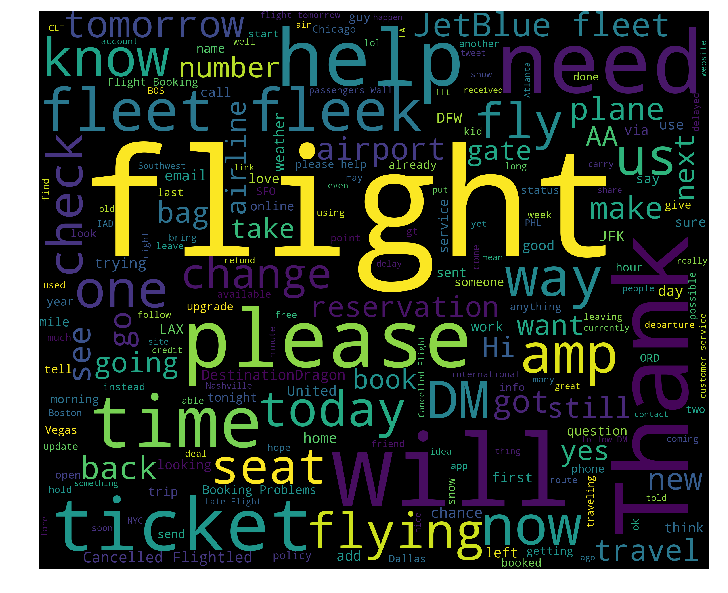

In [22]:
neutral=tw[tw['airline_sentiment']=='neutral']
words = ' '.join(neutral['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Lima kata yang sering muncul pada sentimen netral adalah :
1. Flight
2. Need, help
3. Thank
4. Will
5. Please

**Worcloud untuk Sentimen Positif**

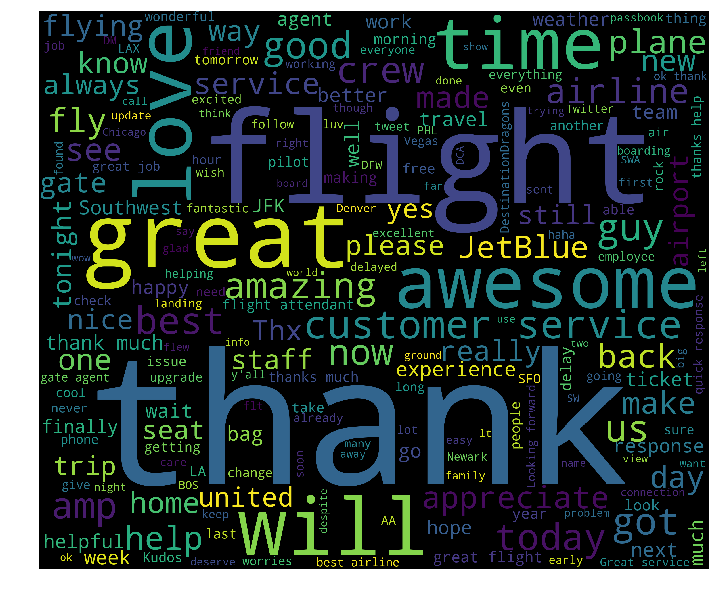

In [23]:
positive=tw[tw['airline_sentiment']=='positive']
words = ' '.join(positive['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Lima kata yang sering muncul pada sentimen positif adalah :
1. Flight
2. Great
3. Awesome
4. Thank
5. Will

**Barchart Airline**

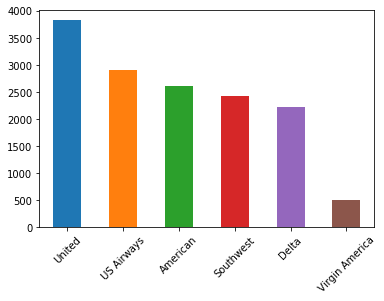

In [24]:
Airline=tw['airline'].sort_index().value_counts()
Airline.plot(kind='bar',rot=45)
plt.show()

Diketahui bahwa dari 6 airline yanga ada di US, urutan airline yang sering dibahas di twitter adalah :
1. United
2. US Airways
3. American
4. Southwest
5. Delta
6. Virgin America

**Barchart Sentimen Berdasarkan Airline**

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2604
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


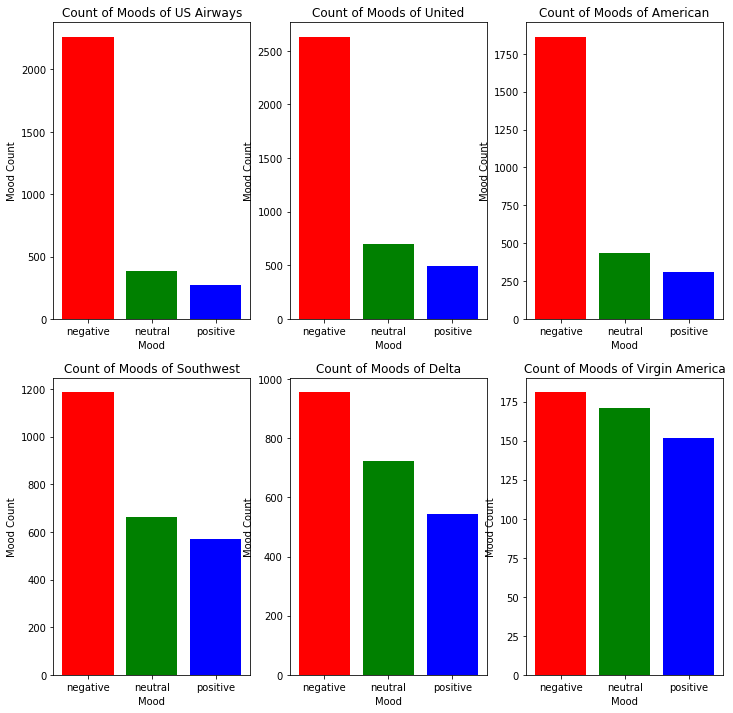

In [25]:
print("Total number of tweets for each airline \n ",tw.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_tw=tw[tw['airline']==i]
    count=new_tw['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

* Pada airline US Airways, United, American, dan Southwest paling banyak dijumpai tweet negatif dan sangat tinggi perbedaannya dengan tweet positif dan netral.
* Pada airline Virgin America jumlah tweet antara negatif, positif, dan netral balance.

**Barchart Alasan Sentimen Negatif Masing-Masing Airline**

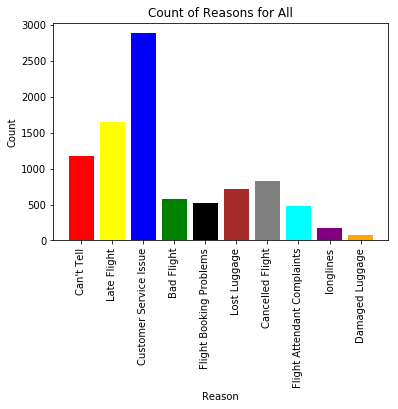

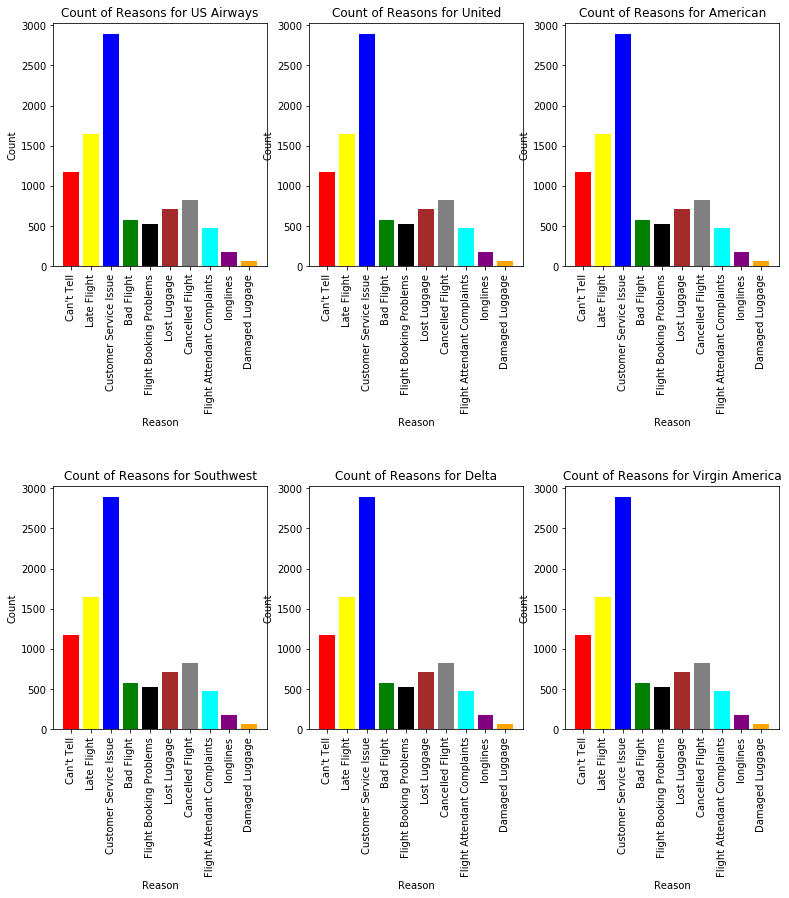

In [26]:
tw['negativereason'].nunique()

NR_Count=dict(tw['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=tw
    else:
        a=tw[tw['airline']==Airline]
    count=dict(tw['negativereason'].value_counts())
    Unique_reason=list(tw['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

Dari keenam airlines (US Airways, United, America, Southwest, Drlta, dan Virgin America, penyebab utama dari sentimen negatif adalah customer service issue.